In [116]:
!pip install pulp pandas matplotlib


[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [147]:
import pandas as pd

# Creating a simple dataset for product pricing optimization
data = {
    'Product_ID': ['P001', 'P002', 'P003', 'P004', 'P005'],
    'Base_Price': [100, 150, 200, 250, 300],
    'Price_Elasticity': [-0.5, -0.7, -0.4, -0.6, -0.3],
    'Current_Demand': [500, 300, 200, 150, 100],
    'Lower_Price_Bound': [80, 120, 180, 220, 250],
    'Upper_Price_Bound': [120, 180, 220, 270, 350],
    'Cost_Price': [60, 100, 120, 150, 180]
}

# Create a DataFrame
df = pd.DataFrame(data)

# Save it to a CSV file
df.to_csv('product_pricing.csv', index=False)

# Display the DataFrame
print(df)

  Product_ID  Base_Price  Price_Elasticity  Current_Demand  Lower_Price_Bound  \
0       P001         100              -0.5             500                 80   
1       P002         150              -0.7             300                120   
2       P003         200              -0.4             200                180   
3       P004         250              -0.6             150                220   
4       P005         300              -0.3             100                250   

   Upper_Price_Bound  Cost_Price  
0                120          60  
1                180         100  
2                220         120  
3                270         150  
4                350         180  


In [148]:
import pulp

# Load the dataset
df = pd.read_csv('product_pricing.csv')

# Create an LP problem
prob = pulp.LpProblem("Optimize_Pricing", pulp.LpMaximize)

# Decision variables: price for each product
price_vars = {}
for i, row in df.iterrows():
    price_vars[row['Product_ID']] = pulp.LpVariable(f"Price_{row['Product_ID']}", 
                                                   lowBound=row['Lower_Price_Bound'], 
                                                   upBound=row['Upper_Price_Bound'], 
                                                   cat='Continuous')

# Objective function: Maximize revenue (Price * Demand * (1 + Price Elasticity))
prob += pulp.lpSum(
    (price_vars[row['Product_ID']] * row['Current_Demand'] * (1 + row['Price_Elasticity'])) 
    for i, row in df.iterrows()), "Total_Revenue"

# Constraints: Ensure price is above cost price + margin
margin = 0.2  # 20% profit margin
for i, row in df.iterrows():
    prob += price_vars[row['Product_ID']] >= row['Cost_Price'] * (1 + margin), f"Price_Above_Cost_{row['Product_ID']}"

# Solve the problem
prob.solve()

# Check the results
print(f"Optimization Status: {pulp.LpStatus[prob.status]}")

# Display optimal prices for each product
for i, row in df.iterrows():
    optimal_price = price_vars[row['Product_ID']].varValue
    print(f"Optimal Price for Product {row['Product_ID']}: {optimal_price:.2f}")

Optimization Status: Optimal
Optimal Price for Product P001: 120.00
Optimal Price for Product P002: 180.00
Optimal Price for Product P003: 220.00
Optimal Price for Product P004: 270.00
Optimal Price for Product P005: 350.00


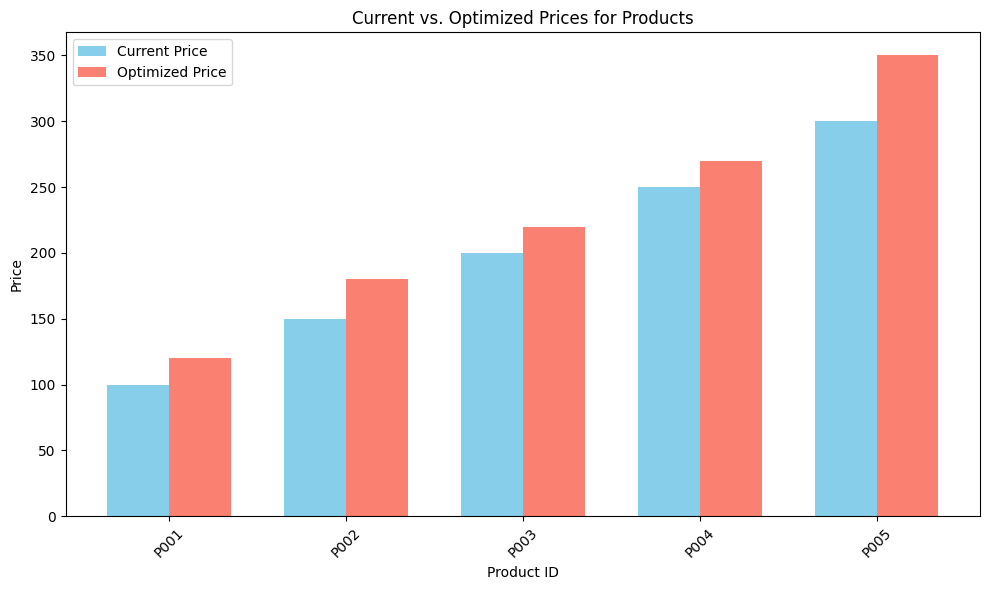

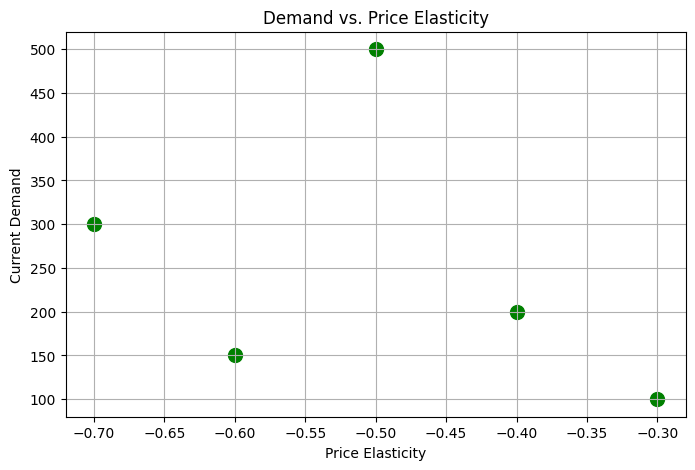

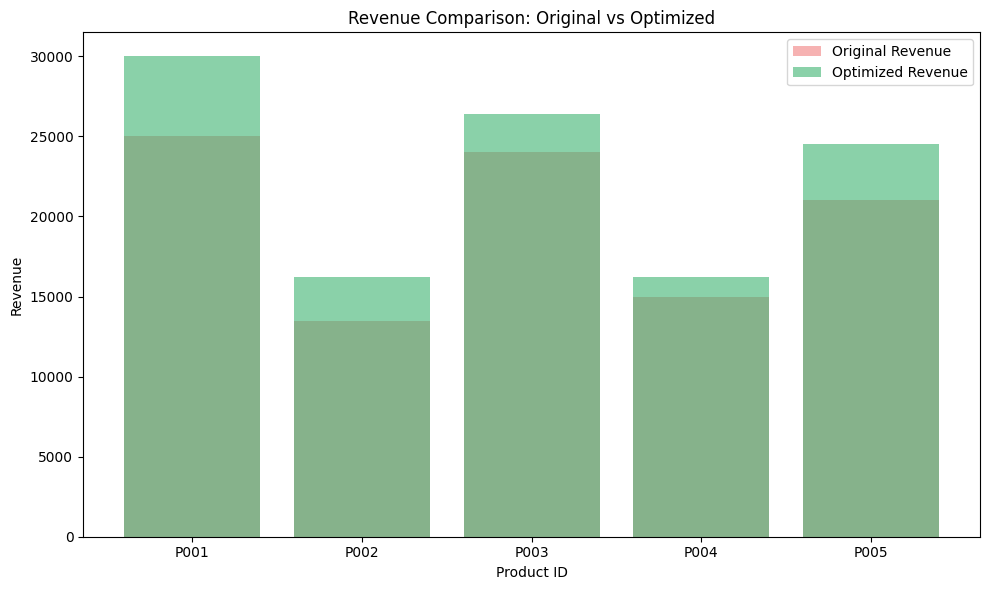

In [149]:
import matplotlib.pyplot as plt
import numpy as np

# Extracting the optimal prices and current prices
optimal_prices = [price_vars[row['Product_ID']].varValue for i, row in df.iterrows()]
current_prices = df['Base_Price'].values

# 1. Bar plot for current vs. optimal prices
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(df))

plt.bar(index, current_prices, bar_width, label='Current Price', color='skyblue')
plt.bar(index + bar_width, optimal_prices, bar_width, label='Optimized Price', color='salmon')

plt.xlabel('Product ID')
plt.ylabel('Price')
plt.title('Current vs. Optimized Prices for Products')
plt.xticks(index + bar_width / 2, df['Product_ID'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Scatter plot for Demand vs. Price Elasticity
plt.figure(figsize=(8, 5))
plt.scatter(df['Price_Elasticity'], df['Current_Demand'], color='green', s=100)
plt.xlabel('Price Elasticity')
plt.ylabel('Current Demand')
plt.title('Demand vs. Price Elasticity')
plt.grid(True)
plt.show()

# 3. Revenue Comparison before and after optimization
original_revenue = [row['Base_Price'] * row['Current_Demand'] * (1 + row['Price_Elasticity']) for i, row in df.iterrows()]
optimized_revenue = [optimal_prices[i] * row['Current_Demand'] * (1 + row['Price_Elasticity']) for i, row in df.iterrows()]

# Plotting the revenue comparison
plt.figure(figsize=(10, 6))
plt.bar(df['Product_ID'], original_revenue, alpha=0.6, label='Original Revenue', color='lightcoral')
plt.bar(df['Product_ID'], optimized_revenue, alpha=0.6, label='Optimized Revenue', color='mediumseagreen')

plt.xlabel('Product ID')
plt.ylabel('Revenue')
plt.title('Revenue Comparison: Original vs Optimized')
plt.legend()
plt.tight_layout()
plt.show()